In [1]:
import numpy as np
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numba
from numba import prange
from time import perf_counter
from scipy.ndimage import convolve, sobel
from scipy import ndimage
from scipy.special import xlogy
from sklearn import preprocessing
from scipy.stats import mode
from scipy.stats import gaussian_kde
from scipy.integrate import quad
import seaborn as sns


# import statistics as statss
%matplotlib inline
sns.set_style("ticks")
sns.set_context("poster")


In [2]:
s = [[1,1,1],
     [1,1,1],
     [1,1,1]]

@numba.njit(parallel=True, fastmath=True)
def lap(u, N):
    """
    Parallel implementation of the laplacian operator with periodic boundary conditions.
    """
    uc = np.empty((N, N))
    for x in numba.prange(1, N-1):
        uc[x, 1:-1] = u[x+1, 1:-1] + u[x-1, 1:-1] + u[x, :-2] + u[x, 2:] - 4*u[x, 1:-1]

    uc[1:-1, 0] = u[1:-1, 1] + u[:-2, 0] + u[2:, 0] + u[1:-1, -1] - 4*u[1:-1, 0]
    uc[1:-1, -1] = u[1:-1, -2] + u[:-2, -1] + u[2:, -1] + u[1:-1, 0] - 4*u[1:-1, -1]
    uc[0, 1:-1] = u[1, 1:-1] + u[0, 2:] + u[0, :-2] + u[-1, 1:-1] - 4*u[0, 1:-1]
    uc[-1, 1:-1] = u[-2, 1:-1] + u[-1, 2:] + u[-1, :-2] + u[0, 1:-1] - 4*u[-1, 1:-1]

    uc[0, 0] = u[0, 1] + u[0, -1] + u[1, 0] + u[-1, 0] - 4*u[0, 0]
    uc[-1, 0] = u[0, 0] + u[-2, 0] + u[-1, -1] + u[-1, -2] - 4*u[-1, 0]
    uc[0, -1] = u[0, 0] + u[0, -2] + u[-1, -1] + u[1, -1] - 4*u[0, -1]
    uc[-1, -1] = u[0, -1] + u[-1, 0] + u[-1, -2] + u[-2, -1] - 4*u[-1, -1]
    return uc


@numba.njit(fastmath=True, parallel=True)
def gray_scott(U, V, Du, Dv, f, k, dt, dx, T):
    """
    Integrates the gray-scott system over time using the given initial
    conditions.
    """
    n = U.shape[0]
    iters = int(T / dt)
    for i in range(iters):
        Lu, Lv = Du*lap(U, n)/dx/dx, Dv*lap(V, n)/dx/dx
        U, V = U + dt*(Lu - U*V*V + f * (1-U)), V + dt*(Lv + U*V*V - (f+k) * V)
    return U, V

def gscott(n, F, k, T, Du=0.16, Dv=0.08, dt=1.0, dx=1.0, seed=5000000):
    """
    Wrapper function that initializes the U and V concentration arrays and the
    random number generator.
        
        n: dimensions of the discretized system
        F: value of F used for the model
        k: value of k used for the model
        T: number of time steps simulated
    
    """
    np.random.seed(seed=seed)
    U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
    r, m = n//40, n//2
    U[...] = 1.0
    V[m-r:m+r, m-r:m+r] = 0.25
    U[m-r:m+r, m-r:m+r] = 0.5
    U += np.random.normal(scale=0.05, size=U.shape)
    V += np.random.normal(scale=0.05, size=V.shape)
    return gray_scott(U, V, Du, Dv, F, k, dt, dx, T)

def calc_objects(inp):
    """
    Calculates the number and size of objects in a given array.
    
    An array is returned with the size of each object, the length of the 
    array thus being the number of objects. A [0] array is returned if
    no objects are found.
    """
    fftding = np.fft.fft2(inp)
    outp = ndimage.fourier_ellipsoid(fftding, 1.1)*100
    outp = np.fft.ifft2(ndimage.fourier_gaussian(outp, 1.01)).real*10

    binarized1 = np.clip(outp-((outp.min() + outp.max())/2), 0, 1)
    labels1 = ndimage.label(binarized1, structure=s)
    binarized2 = np.clip((outp-((outp.min() + outp.max())/2))*-1, 0, 1)
    labels2 = ndimage.label(binarized2, structure=s)
    if labels1[1] > labels2[1]:
        bins, edges = np.histogram(labels1[0], bins=labels1[1])
        return bins[1:]

    # Try inversed region
    if labels2[1] > 1:
        bins, edges = np.histogram(labels2[0], bins=labels2[1])
        return bins[1:]
    
    # No objects
    return np.zeros(1)

In [3]:
def gaus_hack(inp):
    """
    Returns a proper function in the case of a zero pdf, this allows
    the other (nonzero) diagonal element to be calculated.
    """
    if len(np.unique(inp)) == 1:
        return lambda x: 0
    return gaussian_kde(inp)

def fim(x, ind, pdfs, df, dk):
    """
    Slightly inelegant function which calculates all elements of the fisher information matrix
    dependent on the input index: 
        (1,1) = G_kk
        (0,1) (1,0) = G_Fk
        (0,0) = G_FF
    
    The order in the pdfs list should be: {0 := theta}
        [p(x|0), p(x|0+dk), p(x|0-dk), p(x|0+dF), p(x|0-dF)]
    """
    # catches the (1, 1) index
    if np.all(ind):
        vals = np.array([pdfs[0](x), pdfs[1](x), pdfs[2](x)])
        if np.any(vals < 1e-8):
            return 0.0
        return vals[0] * (np.log(vals[1]) - np.log(vals[2]))**2 / (4.0 * dk * dk)
    
    # catches the (1, 0) or (0, 1) index
    elif np.any(ind):
        vals = np.array([i(x) for i in pdfs])
        if np.any(vals < 1e-8):
            return 0.0
        return vals[0] * (np.log(vals[1]) - np.log(vals[2]))\
               * (np.log(vals[3]) - np.log(vals[4])) / (4.0 * df * dk)
    
    # (0, 0) index otherwise
    vals = np.array([pdfs[0](x), pdfs[3](x), pdfs[4](x)])
    if np.any(vals < 1e-8):
        return 0.0
    return vals[0] * (np.log(vals[1]) - np.log(vals[2]))**2 / (4.0 * df * df)
    
def fisher_matrix(inps, df, dk):
    """
    Computes the 2x2 fisher information matrix from a list of 5 blob size distributions
    """
    p = [gaus_hack(i) for i in inps]
    FIM = np.zeros((2, 2))
    for i in np.ndindex(2, 2):
        FIM[i] = quad(fim, -np.inf, np.inf, args=(i, p, df, dk), limit=1000)[0]
    return FIM



def bulk_fisher(f, k, df, dk, n=250, T=20000):
    """
    Computes the FIM for the plane of points between the given f and k.
    """
    iters = len(f) * len(k)
    
    f, k = np.meshgrid(f, k)
    outp = np.zeros((*f.shape, 2, 2))
    for index, _f in tqdm(np.ndenumerate(f), total=iters):
        u, v = gscott(n, _f, k[index], T)
        u1,v1 = gscott(n, _f, k[index]+dk, T)
        u2,v2 = gscott(n, _f, k[index]-dk, T)
        u3,v3 = gscott(n, _f+df, k[index], T)
        u4,v4 = gscott(n, _f-df, k[index], T)
        
        inputs = [calc_objects(x) for x in [u, u1, u2, u3, u4]]
        outp[index] = fisher_matrix(inputs, df, dk)
    return outp

def bulk_fisher1d(f, k, df, dk, n=250, T=20000):
    """
    Computes the FIM for a 1D trajectory over the pairs of f and k.
    """
    iters = len(f)
    
    outp = np.zeros((len(f), 2, 2))
    for index, _f in tqdm(np.ndenumerate(f), total=iters):
        u, v = gscott(n, _f, k[index], T)
        u1,v1 = gscott(n, _f, k[index]+dk, T)
        u2,v2 = gscott(n, _f, k[index]-dk, T)
        u3,v3 = gscott(n, _f+df, k[index], T)
        u4,v4 = gscott(n, _f-df, k[index], T)
        
        inputs = [calc_objects(x) for x in [u, u1, u2, u3, u4]]
        outp[index] = fisher_matrix(inputs, df, dk)
    return outp

# Computes the fisher information interval over the first trajectory

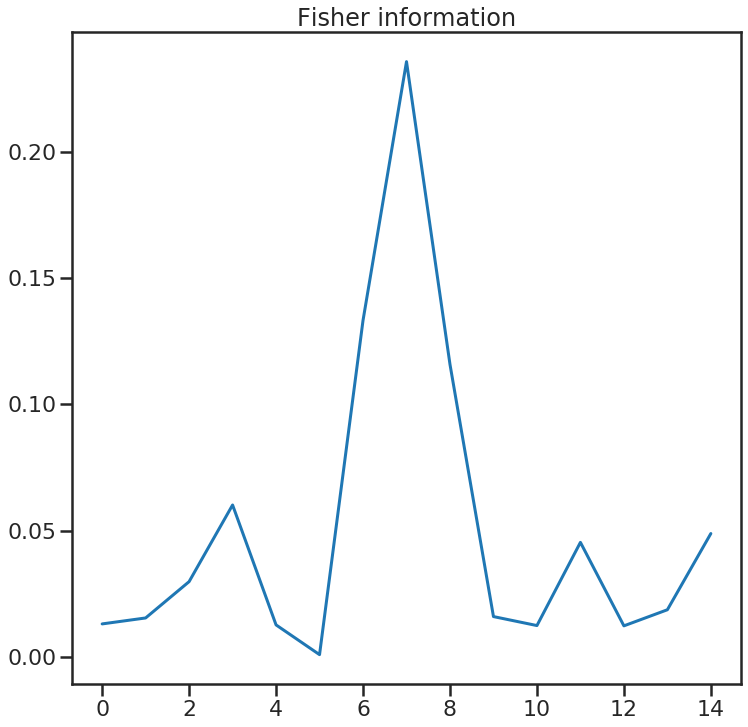

In [9]:
df = 0.0001
dk = 0.0001
f_min = 0.0238191
f_max = 0.0271360
k_min = 0.05869347
k_max = 0.06141

p1 = np.array([k_min, f_min])
p2 = np.array([k_max, f_max])
dr = (p2 - p1)/np.linalg.norm(p2 - p1)
dtheta = np.vdot([dk, df], dr)

# f = np.linspace(f_min, f_max, 250)
# k = np.linspace(k_min, k_max, 250)
f = np.linspace(f_min, f_max, 15)
k = np.linspace(k_min, k_max, 15)


# outp = bulk_fisher1d(f, k,dk,df)
outp = bulk_fisher1d(f, k,dk,df, n=150, T=5000)


ds2 = [x[0,1]*dtheta*dtheta for x in outp]
plt.figure(figsize=(12,12))
plt.plot(np.abs(ds2))
plt.title("Fisher information")
plt.show()
# np.savetxt("ds2", np.array(ds2))

# Computes the Fisher information interval over the second trajectory

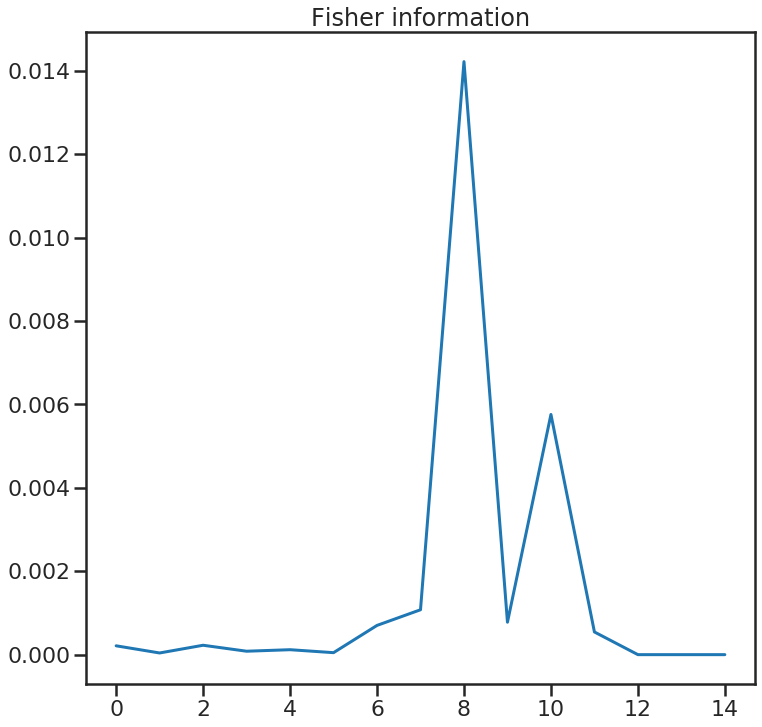

In [10]:
df = 0.0001
dk = 0.0001
f1 = 0.0395
f2 = 0.04228
k1 = 0.0652
k2 = 0.0632

# k = np.linspace(k1, k2, 250)
# f = np.linspace(f1, f2, 250)
k = np.linspace(k1, k2, 15)
f = np.linspace(f1, f2, 15)


p1 = np.array([k1, f1])
p2 = np.array([k2, f2])
dr = (p2 - p1)/np.linalg.norm(p2 - p1)
dtheta = np.vdot([dk, df], dr)

# outp2 = bulk_fisher1d(f, k,dk,df)
outp2 = bulk_fisher1d(f, k,dk,df, n=150, T=5000)


ds2v2 = [x[0,1]*dtheta*dtheta for x in outp2]
# np.savetxt("ds2v2", np.array(ds2v2))
plt.figure(figsize=(12,12))
plt.plot(np.abs(ds2v2))
plt.title("Fisher information")
plt.show()